In [ ]:
# Setup for Google Colab (optional)
import sys
if 'google.colab' in sys.modules:
    print("Running in Google Colab")
    # Install required packages
    !pip install -q py4DSTEM hyperspy scikit-image matplotlib numpy scipy
    
    # Clone the repository to access data
    !git clone -q https://github.com/NU-MSE-LECTURES/465-WINTER2026.git
    import os
    os.chdir('/content/465-WINTER2026')
    
    # Set up file handling
    from google.colab import files
    print("Colab setup complete!")
else:
    print("Running in local environment")

<a href="https://colab.research.google.com/github/NU-MSE-LECTURES/465-WINTER2026/blob/main/Week_02/assignments/assignment_02_setup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 02: 4D-STEM Foundations

Complete this assignment to demonstrate your understanding of 4D-STEM data analysis and calibration.


In [1]:
# Colab setup
try:
    import google.colab
    IN_COLAB = True
    print("Running in Google Colab. Installing requirements...")
    !pip install hyperspy ase py4DSTEM
    !git clone https://github.com/NU-MSE-LECTURES/465_Computational_Microscopy_2026.git
    print("Setup complete.")
except ImportError:
    IN_COLAB = False
    print("Not running in Google Colab.")

Not running in Google Colab.


In [2]:
import py4DSTEM, sys
print(py4DSTEM.__version__)
print(sys.executable)
print(py4DSTEM.__file__)


0.14.18
C:\Users\pkwki\anaconda3\envs\matsci465\python.exe
C:\Users\pkwki\anaconda3\envs\matsci465\lib\site-packages\py4DSTEM\__init__.py


## Task 1: Distinguish Navigation vs. Signal Axes

In your notebook, define the "Navigation Axes" (where the measurement is made, e.g., x, y scan positions).

Define the "Signal Axes" (what is measured at each point, e.g., an EELS spectrum or a 2D diffraction pattern).

Use signal.axes manager to print and verify the dimensionality of a 4D-STEM dataset (expected: 2 Navigation, 2 Signal).

In [1]:
import numpy as np
import hyperspy.api as hs
import py4DSTEM

DATA_PATH = r"C:\Users\pkwki\Downloads\Si-SiGe.dm4"

def load_4dstem(path):
    if hasattr(py4DSTEM, "io") and hasattr(py4DSTEM.io, "import_file"):
        return py4DSTEM.io.import_file(path)
    return py4DSTEM.import_file(path)

def reorder_to_scan_scan_dp_dp(arr):
    a, b, c, d = arr.shape
    if a > 100 and b > 100 and c < 100 and d < 100:
        arr = np.transpose(arr, (2, 3, 0, 1))
    return arr

dataset = load_4dstem(DATA_PATH)
data4d = reorder_to_scan_scan_dp_dp(dataset.data)

print("4D-STEM data shape:", data4d.shape)

signal = hs.signals.Signal2D(data4d)
am = signal.axes_manager

print("Navigation dimensions:", am.navigation_dimension)
print("Signal dimensions:", am.signal_dimension)

print("\nNavigation axes:")
for ax in am.navigation_axes:
    print(f"  size={ax.size}, units={ax.units}")

print("\nSignal axes:")
for ax in am.signal_axes:
    print(f"  size={ax.size}, units={ax.units}")


4D-STEM data shape: (77, 17, 480, 448)


get_file_handle has been moved to `rsciio.utils.file` and will be removed from `rsciio.utils.tools` in version 1.0.
The module `rsciio.utils.rgb_tools` has been renamed to `rsciio.utils.rgb` and it will be removed in version 1.0.
ensure_directory has been moved to `rsciio.utils.path` and will be removed from `rsciio.utils.tools` in version 1.0.
append2pathname has been moved to `rsciio.utils.path` and will be removed from `rsciio.utils.tools` in version 1.0.
incremental_filename has been moved to `rsciio.utils.path` and will be removed from `rsciio.utils.tools` in version 1.0.
ensure_directory has been moved to `rsciio.utils.path` and will be removed from `rsciio.utils.tools` in version 1.0.
overwrite has been moved to `rsciio.utils.path` and will be removed from `rsciio.utils.tools` in version 1.0.


Navigation dimensions: 2
Signal dimensions: 2

Navigation axes:
  size=17, units=<undefined>
  size=77, units=<undefined>

Signal axes:
  size=448, units=<undefined>
  size=480, units=<undefined>


Navigation axes correspond to the probe scan positions in real space (y, x) where diffraction patterns are recorded.
Signal axes correspond to the measured signal at each probe position. In 4D-STEM, this signal is a 2D diffraction pattern in reciprocal space.
Using signal.axes_manager, this dataset is verified to have 2 navigation axes and 2 signal axes.

## Task 2: Load and Calibrate 4D-STEM Data

Use py4DSTEM.io.read to load a 4D-STEM dataset (e.g., .dm4 or .h5).

**Note:** The dataset Si-SiGe.dm4 should be available in the raw_data folder.

Set the scan step size (real space calibration) using dataset.set_scan_step_size().

Perform Center of Mass (CoM) correction using dataset.get_diffraction_shifts() to center the unscattered beam.

Loaded: C:\Users\pkwki\Downloads\Si-SiGe.dm4
Original shape: (480, 448, 77, 17)
Transposing (qy,qx,sy,sx) -> (sy,sx,qy,qx)
Working shape (sy,sx,qy,qx): (77, 17, 480, 448)
Scan step size set to: 2.0 nm


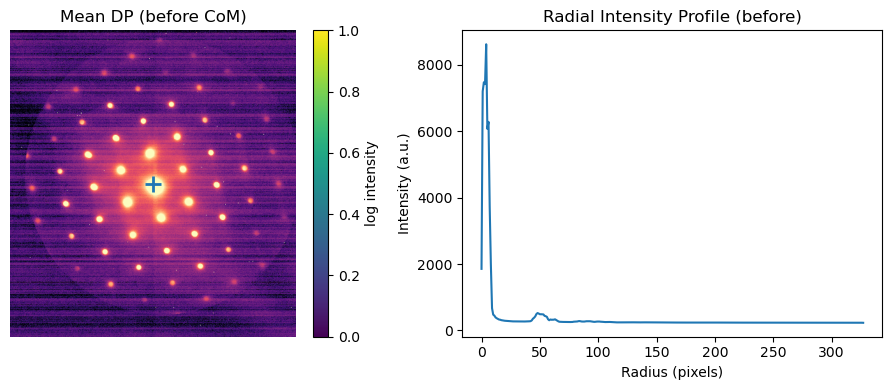

CoM centering applied (sub-pixel Fourier shift).


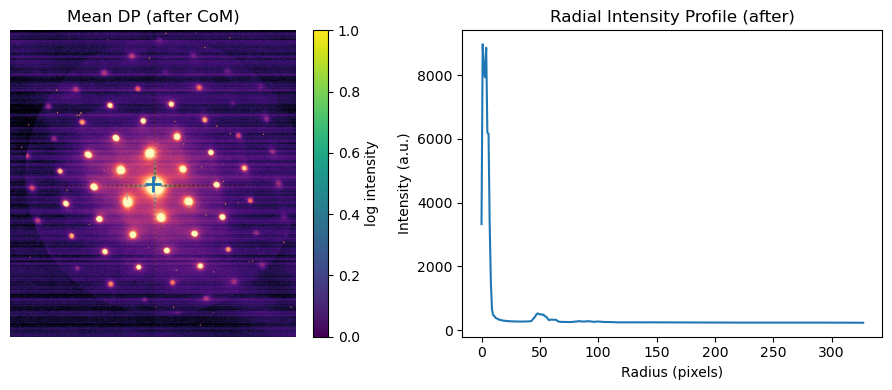

Task 2 complete


In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt
import py4DSTEM

# for sub-pixel shifts )
from scipy.ndimage import fourier_shift

# 1) Load dataset (.dm4) 
DATA_PATH = r"C:\Users\pkwki\Downloads\Si-SiGe.dm4"
assert os.path.exists(DATA_PATH), f"File not found: {DATA_PATH}"

dc = py4DSTEM.io.import_file(DATA_PATH)   
data = dc.data
print("Loaded:", DATA_PATH)
print("Original shape:", data.shape)

# Ensure axis order is (scan_y, scan_x, qy, qx) 
# file commonly loads as (qy, qx, scan_y, scan_x)
if data.shape[0] > 100 and data.shape[1] > 100 and data.shape[2] < 200 and data.shape[3] < 200:
    print("Transposing (qy,qx,sy,sx) -> (sy,sx,qy,qx)")
    data = np.transpose(data, (2, 3, 0, 1))

print("Working shape (sy,sx,qy,qx):", data.shape)

# 3) Scan step size (2.0 nm) 
SCAN_STEP_NM = 2.0
dc.scan_step_nm = SCAN_STEP_NM
print("Scan step size set to:", SCAN_STEP_NM, "nm")

# Helper functions
def com2d(img):
    img = img.astype(float)
    s = img.sum() + 1e-12
    yy, xx = np.indices(img.shape)
    cy = (yy * img).sum() / s
    cx = (xx * img).sum() / s
    return cy, cx

def radial_profile(img, center):
    yy, xx = np.indices(img.shape)
    cy, cx = center
    r = np.sqrt((yy - cy)**2 + (xx - cx)**2)
    r_int = r.astype(int)
    tbin = np.bincount(r_int.ravel(), weights=img.ravel())
    nr = np.bincount(r_int.ravel())
    return tbin / np.maximum(nr, 1)

def shift_subpixel(dp, dy, dx):
    # Fourier subpixel shift (smooth, close to py4DSTEM interpolation behavior)
    f = np.fft.fftn(dp)
    f_shifted = fourier_shift(f, shift=(dy, dx))
    out = np.fft.ifftn(f_shifted).real
    return out

# 4) Mean DP BEFORE centering 
mean_before = data.mean(axis=(0, 1))
cy0, cx0 = com2d(mean_before)

img0 = np.log10(mean_before - mean_before.min() + 1.0)
vmin0, vmax0 = np.percentile(img0, [1, 99])

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(img0, cmap="magma", vmin=vmin0, vmax=vmax0)
plt.scatter([cx0], [cy0], marker="+", s=140, linewidths=2)
plt.title("Mean DP (before CoM)")
plt.axis("off")
plt.colorbar(label="log intensity", fraction=0.046, pad=0.04)

rp0 = radial_profile(mean_before, (cy0, cx0))
plt.subplot(1, 2, 2)
plt.plot(np.arange(len(rp0)), rp0)
plt.title("Radial Intensity Profile (before)")
plt.xlabel("Radius (pixels)")
plt.ylabel("Intensity (a.u.)")
plt.tight_layout()
plt.show()

# 5) CoM centering (compute shifts per scan point, apply sub-pixel shift) 
sy, sx, qy, qx = data.shape
target = ((qy - 1) / 2.0, (qx - 1) / 2.0)  # detector center
ty, tx = target

centered = np.empty_like(data, dtype=float)

for iy in range(sy):
    for ix in range(sx):
        dp = data[iy, ix].astype(float)
        cy, cx = com2d(dp)
        dy = ty - cy
        dx = tx - cx
        centered[iy, ix] = shift_subpixel(dp, dy, dx)

# write back
dc.data = centered
print("CoM centering applied (sub-pixel Fourier shift).")

# 6) Mean DP AFTER centering 
mean_after = dc.data.mean(axis=(0, 1))
cy1, cx1 = com2d(mean_after)

img1 = np.log10(mean_after - mean_after.min() + 1.0)
vmin1, vmax1 = np.percentile(img1, [1, 99])

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(img1, cmap="magma", vmin=vmin1, vmax=vmax1)
plt.scatter([cx1], [cy1], marker="+", s=140, linewidths=2)
plt.title("Mean DP (after CoM)")
plt.axis("off")
plt.colorbar(label="log intensity", fraction=0.046, pad=0.04)

rp1 = radial_profile(mean_after, (cy1, cx1))
plt.subplot(1, 2, 2)
plt.plot(np.arange(len(rp1)), rp1)
plt.title("Radial Intensity Profile (after)")
plt.xlabel("Radius (pixels)")
plt.ylabel("Intensity (a.u.)")
plt.tight_layout()
plt.show()

print("Task 2 complete")


## Task 3: Virtual Detector Reconstruction

Generate a Virtual Bright Field (BF) image by integrating the central transmitted disk.

Generate an Annular Dark Field (ADF) image by integrating the scattered electrons in an outer ring.

Compare the Z-contrast in the ADF image to the diffraction contrast in the BF image.

Task 3 data shape: (77, 17, 480, 448)


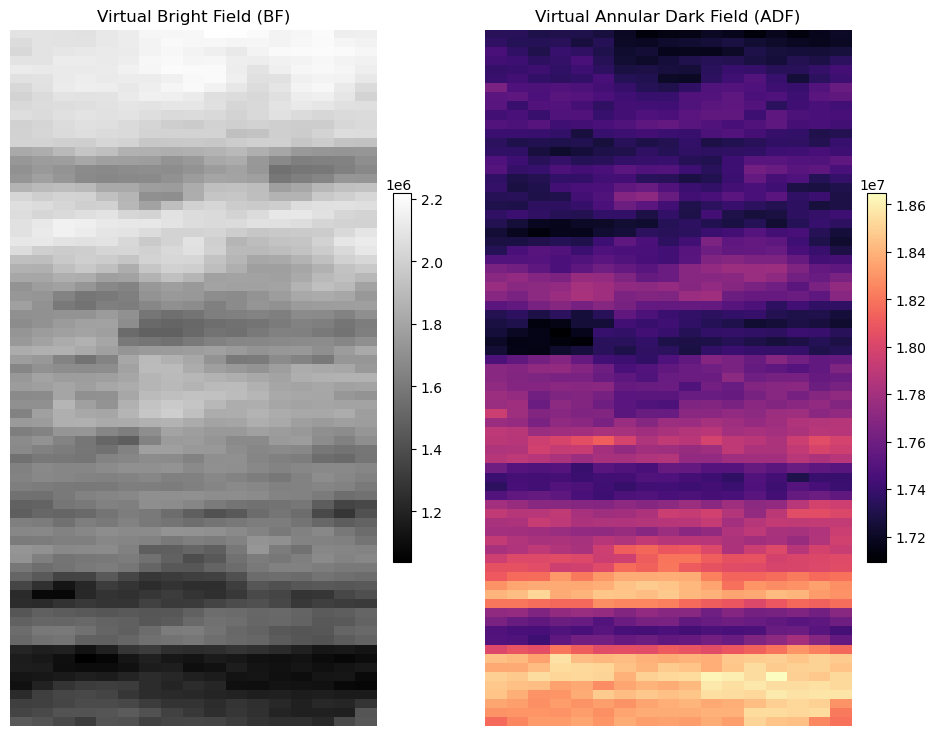

Task 3 complete.


In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Load 4D-STEM data (scan_y, scan_x, qy, qx)
data4d = dc.data
print("Task 3 data shape:", data4d.shape)

# Unpack dimensions
sy, sx, qy, qx = data4d.shape

# Mean diffraction pattern to locate beam center
mean_dp = data4d.mean(axis=(0, 1))
yy, xx = np.indices((qy, qx))

# Center of mass of diffraction pattern
def center_of_mass(img):
    s = img.sum() + 1e-12
    cy = (yy * img).sum() / s
    cx = (xx * img).sum() / s
    return cy, cx

cy, cx = center_of_mass(mean_dp)

# Radial distance from beam center
r = np.sqrt((yy - cy)**2 + (xx - cx)**2)

# Virtual detector definitions
bf_radius = 20
adf_inner = 40
adf_outer = 150

bf_mask = (r <= bf_radius).astype(float)
adf_mask = ((r >= adf_inner) & (r <= adf_outer)).astype(float)

# Integrate diffraction patterns
bf_img = np.tensordot(data4d, bf_mask, axes=([2, 3], [0, 1]))
adf_img = np.tensordot(data4d, adf_mask, axes=([2, 3], [0, 1]))

# Plot BF and ADF images
fig, axes = plt.subplots(1, 2, figsize=(10, 8))

im1 = axes[0].imshow(bf_img, cmap="gray", aspect="auto")
axes[0].set_title("Virtual Bright Field (BF)")
axes[0].axis("off")
plt.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)

im2 = axes[1].imshow(adf_img, cmap="magma", aspect="auto")
axes[1].set_title("Virtual Annular Dark Field (ADF)")
axes[1].axis("off")
plt.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)

plt.tight_layout(pad=3.0)
plt.show()

print("Task 3 complete.")


BF (Virtual Bright Field): integrates the central transmitted disk (low-angle scattering). 
BF contrast is strongly affected by diffraction conditions (orientation/strain), so it often shows diffraction/phase contrast.

ADF (Virtual Annular Dark Field):integrates an outer annulus (higher-angle scattering). 
ADF suppresses most diffraction contrast and instead emphasizes mass–thickness / approximate Z-contrast: thicker or higher-Z regions appear brighter.

In this dataset, the ADF image shows stronger intensity variations consistent with Z/mass-thickness contrast, while the BF image appears smoother and more dominated by diffraction-related contrast.


## Task 4: Basic 4D-STEM Visualization

Launch the interactive 4D-STEM browser using dataset.show() (if using a local GUI) or py4D.show_image().

Export a publication-quality figure of a virtual ADF image with a scale bar and a perceptually uniform colormap (e.g., magma).

adf_img shape: (77, 17)


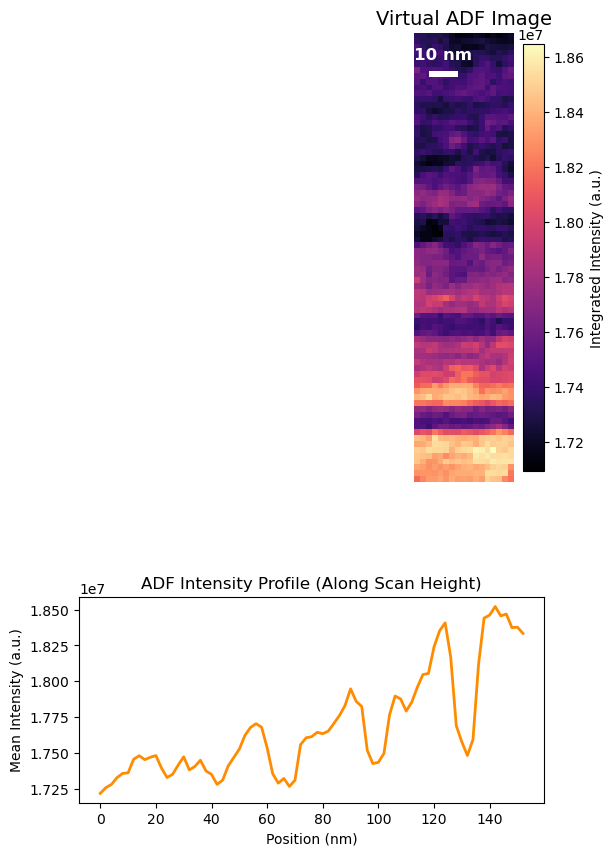

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# ---- ensure ADF is oriented (tall: scan_y x scan_x) ----
print("adf_img shape:", adf_img.shape)

adf_plot = adf_img
if adf_plot.shape[0] < adf_plot.shape[1]:
    adf_plot = adf_plot.T   # fix if swapped

# ---- parameters ----
pixel_size_nm = 2.0          
scale_bar_nm = 10
scale_bar_px = scale_bar_nm / pixel_size_nm

# ---- ADF line profile (along scan height = vertical axis) ----
line_profile = np.mean(adf_plot, axis=1)
scan_axis_nm = np.arange(len(line_profile)) * pixel_size_nm

# ---- plot ----
fig = plt.figure(figsize=(6, 10))
gs = fig.add_gridspec(2, 1, height_ratios=[3.5, 1.6], hspace=0.35)

# ADF image
ax1 = fig.add_subplot(gs[0])
im = ax1.imshow(adf_plot, cmap="magma", aspect="equal")  # key: equal keeps pixels square
ax1.set_title("Virtual ADF Image", fontsize=14)
ax1.axis("off")

# scale bar (top-left)
bar_x, bar_y = 2, 6
rect = Rectangle((bar_x, bar_y), scale_bar_px, 1, facecolor="white", linewidth=0)
ax1.add_patch(rect)
ax1.text(bar_x + scale_bar_px/2, bar_y - 1.5, f"{scale_bar_nm} nm",
         color="white", ha="center", va="bottom", fontsize=12, fontweight="bold")

cbar = fig.colorbar(im, ax=ax1, fraction=0.046, pad=0.02)
cbar.set_label("Integrated Intensity (a.u.)")

# line profile
ax2 = fig.add_subplot(gs[1])
ax2.plot(scan_axis_nm, line_profile, color="darkorange", linewidth=2)
ax2.set_title("ADF Intensity Profile (Along Scan Height)")
ax2.set_xlabel("Position (nm)")
ax2.set_ylabel("Mean Intensity (a.u.)")

plt.savefig("virtual_adf_publication.png", dpi=300, bbox_inches="tight")
plt.show()


## Task 5: Finalize and Submit

Update your README.md with a brief explanation of how virtual detectors allow post-acquisition imaging.

Push the completed Week 02 notebook to your GitHub repository.

Submit the repository link on Canvas.